In [106]:
import pandas, importlib, re, collections
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import countsColumnsNaming
import vennMaker
import peaksList
import heatmap
import utils
import figureMaker
import countsFileIO

"""
Figure 4A:
Boxplot of '% of reads in target RNAs (per RNA)' vs block.

Figure 4B:
Boxplot of '% of reads in target RNAs (entire block)' vs block.
"""

from blocks import blocki, blockii, blockiii
importlib.reload(countsFileIO)
print(countsFileIO.__file__)


/Users/dfporter/Desktop/macbook_air_Desktop/shared/sp_oo/FBF_gendered_gl/cliputil/countsFileIO.py


SP FBF (25°C)
SP FBF-2 (25°C)
SP FBF-1 (25°C)
OO FBF-2 (20°C)
OO FBF (25°C)
OO FBF-1 (20°C)


/Users/dfporter/pma/venv/lib/python3.6/site-packages/pandas/util/_decorators.py:118: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  return func(*args, **kwargs)


OO FBF-2 (25°C)
OO FBF-1 (25°C)
Loading ../v2/combined_counts.txt as combined counts file.
RNA genes: 6
['rrn-4.5', 'rrn-4.16', 'rrn-2.1', 'rrn-3.56', 'rrn-3.1', 'rrn-4.15']

> ['LT FBF2_1', 'SP FBF_2', 'control_sp_1', 'LT FBF1_1', 'control_oo_3', 'LT FBF1_2', 'control_sp', 'OO FBF_2', 'control_oo_1', 'control_sp_3', 'control_oo', 'SP FBF_3', 'OO FBF_1', 'LT FBF2_3', 'control_oo_2', 'LT FBF1_3', 'OO FBF_3', 'SP FBF_1', 'control_sp_2', 'LT FBF2_2']
Using SP FBF (25°C)
Using OO FBF (25°C)
           LT FBF2_1  SP FBF_2  LT FBF1_1  LT FBF1_2  OO FBF_2  SP FBF_3  \
gene                                                                       
Y57A10A.8        205       113        321        294        78       133   
sqv-5           1439       644       2493       2223       733       647   

           OO FBF_1  LT FBF2_3  LT FBF1_3  OO FBF_3  SP FBF_1  LT FBF2_2  
gene                                                                      
Y57A10A.8        28        143        111       189  

/Users/dfporter/pma/venv/lib/python3.6/site-packages/seaborn/categorical.py:1508: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


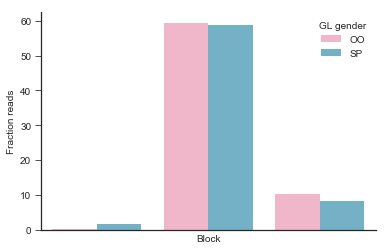

/Users/dfporter/pma/venv/lib/python3.6/site-packages/seaborn/categorical.py:490: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])


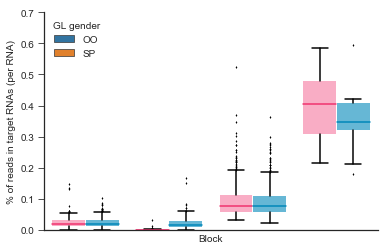

In [124]:

v = figureMaker.figureMaker()
importlib.reload(countsFileIO)
v.load_peaks_from_excel_file('../v2/tables/Table S1 Peaks.xls')
#print(v.df.keys())

cfi = countsFileIO.countsFileIO()

df = cfi.load_counts_file(
    fname='../v2/combined_counts.txt',
    log_scale=False, total_read_numbers='../v2/total_read_numbers.txt',
    style='raw')

targets = set()
for sheet_name, target_set in v.targs.items():
    if re.search('20°C', sheet_name) or re.search('FBF-\d', sheet_name):
        pass
    else:
        print('Using {}'.format(sheet_name))
        targets |= target_set

df = df[[(x in targets) for x in df.index]].copy()
print(df.head(2))
print('-----')

rows = []

def assign_to_block(gene_name):
    if gene_name in blocki:
        return 'I'
    if gene_name in blockii:
        return 'II'
    if gene_name in blockiii:
        return 'III'
    return "Not in block"

df['OO'] = df[['OO FBF_1', 'OO FBF_2', 'OO FBF_3']].mean(axis=1)
df['SP'] = df[['SP FBF_1', 'SP FBF_2', 'SP FBF_3']].mean(axis=1)
df = df[['OO', 'SP']].copy()
print(df)

to_total = {}
for col in df.columns:
    to_total[col] = df[col].sum()

print('--')
def flatten(df):
    
    flat = []
    sums = collections.defaultdict(float)
    
    for col in df.columns:
        
        gl_gender = 'OO'
        if re.search('SP', col):
            gl_gender = 'SP'
            
        for gene, val in zip(df.index, df[col]):
            flat.append({
                'Gene name': gene,
                'GL gender': gl_gender,
                '% of reads in target RNAs (per RNA)': 100 * val/to_total[col],
                'Block': assign_to_block(gene)
            })
            
            sums[(gl_gender,  assign_to_block(gene))] += 100 * val/to_total[col]
    
    sum_df = []
    for (gender, block), _sum in sums.items():
        sum_df.append({
            'GL gender': gender,
            'Block': block,
            'Fraction reads': _sum
        })

    return pandas.DataFrame(flat), pandas.DataFrame(sum_df)

flat, sum_df = flatten(df)

print(flat.head())
print('--zzzz', sum_df)
totals = flat.groupby(['Block', 'GL gender'])['% of reads in target RNAs (per RNA)'].sum()
totals = pandas.DataFrame(totals)

print(totals)

# Draw figures.
plt.clf()
fig = plt.figure()
sns.set_style('ticks')

sum_df = sum_df[[x != 'Not in block' for x in sum_df.index]].copy()
ax = sns.barplot(
    x='Block', y='Fraction reads', hue='GL gender', data=sum_df,
    order=['I', 'II', 'III'], palette=['#F9ADC5',  '#66B7D5'])
sns.despine()
ax.set_xticks([])
plt.savefig('../v2/figs/Figure 4B barplot.pdf')
plt.show()
plt.clf()
plt.close()

fig = plt.figure()
#sns.set_style({'xtick.bottom': False})

ax = sns.boxplot(
    data=flat, x='Block', y='% of reads in target RNAs (per RNA)', hue='GL gender',
    fliersize=2, 
    order=['Not in block', 'I', 'II', 'III']
)

ax.set_xticks([])

for i,artist in enumerate(ax.artists):
    
    col = 'k'
    artist.set_edgecolor('None')
    
    if i % 2:
        gender_face = '#66B7D5' # 'sp'
        gender_med = '#0087B9'
    else:
        gender_face = '#F9ADC5' # 'oo'
        gender_med = '#F0326E'
        
    artist.set_facecolor(gender_face)

    # Loop through the 6 associated Line2D objects of each box to set colors.
    # Loop over the lines colored by gender.
    for j in range(i*6+4,i*6+6):
        line = ax.lines[j]
        line.set_color(gender_med)
        line.set_mfc(col)
        line.set_mec('None')
    
    # Loop over the lines colored black.
    for j in range(i*6, i*6+4):
        line = ax.lines[j]
        line.set_color('k')
        line.set_mfc('None')
        line.set_mec('None')
        
plt.ylim(0, 0.7)
sns.despine()

plt.savefig('../v2/figs/Figure 4A boxplot.pdf')
plt.show()
plt.clf()
plt.close()
rnaseq = '/opt/lib/ortiz/DESeq_genes_in_gonad.txt'
rnaseq = pandas.read_csv(rnaseq, sep='\t')


    